# GPTellMeTheAnswer: Comparing large language model answers against retrieved documents.

This project focuses on the comparison between answers generated by large language models and the answers from retrieved documents.

## Setup

In [ ]:
import os

if not os.path.isfile('raw.tar.gz'):
  !wget http://blob.thijs.ai/wiki-summary-dataset/raw.tar.gz
  !tar -xvzf raw.tar.gz


In [ ]:
# Do pip installs
!pip install transformers torch scikit-learn gensim pandas sentencepiece einops accelerate rank-bm25 wordcloud auto-gptq optimum sentence-transformers

# hot version of transformers
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-suqo8kr2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-suqo8kr2
  Resolved https://github.com/huggingface/transformers to commit 2272ab57a99bcac972b5252b87c31e24d0b25538
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import random
import numpy as np

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, LlamaTokenizer, MistralForCausalLM
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

from sentence_transformers import SentenceTransformer
import scipy.spatial

from wordcloud import WordCloud
import matplotlib.pyplot as plt

device = "cpu"

if torch.cuda.is_available():
  device = "cuda"

## Model init, generation function and dataset read

In [ ]:
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# We dont really trust remote microsoft code but whatever
print(device)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", device_map=device, trust_remote_code=True).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

data = []

# Read file line by line, else we die because pandas will try to shove the entire
# contents of the file into memory at once, unless we chunk it, which was also weird
with open('raw.txt', 'r') as file:
    for line in file:
        try:
            word, summary = line.strip().split('|||')
            data.append((word.strip(), summary.strip()))
        except ValueError:
            print(f"Skipping irregular line: {line}")

df = pd.DataFrame(data, columns=['word', 'summary'])

df['word'] = df['word'].str.strip()
df['summary'] = df['summary'].str.strip()

# Five Million (dollars!) entires
print(len(df.index))
print(df.head())

Skipping irregular line: Unary numeral system ||| The unary numeral system is the bijective base-1 numeral system. It is the simplest numeral system to represent natural numbers: in order to represent a number N, an arbitrarily chosen symbol representing 1 is repeated N times. For examples, the numbers 1, 2, 3, 4, 5, ... would be represented in this system as 1, 11, 111, 1111, 11111, ... These numbers should be distinguished from repunits, which are also written as sequences of ones but have their usual decimal numerical interpretation. This system is used in tallying. For example, using the tally mark |, the number 3 is represented as |||. In East Asian cultures, the number three is represented as “三”, a character that is drawn with three strokes.

Skipping irregular line: Tiny and miny ||| In mathematics, tiny and miny are operators that yield infinitesimal values when applied to numbers in combinatorial game theory. Given a positive number G, tiny G (denoted by ⧾G in many texts) is 

In [ ]:
# We obviously want to sample a smaller portion of the dataset, since
# running over the whole thing would take a _long_ time
sampsize = 50
#sub = df.sample(n=sampsize, random_state=np.random.RandomState())
sub = df.sample(n=sampsize, random_state=1)

sub.head()

,word,summary
2539278,Saimoni Tamani,Saimoni Tamani (born 14 November 1944) is a Fi...
350610,Sorrento Peninsula,The Sorrento Peninsula or Sorrentine Peninsula...
2399294,Dual Work Exchanger Energy Recovery,The Dual Work Exchanger Energy Recovery (DWEER...
4204934,Roswell George Mills,Roswell George Mills (1896 - 1966) was a Canad...
199369,Danish cuisine,"Danish cuisine (Danish: det danske køkken), or..."


In [ ]:
generated_summaries = {}
original_summaries = {}

# Iter over subset and for each term we generate a summary
for index, row in sub.iterrows():
    word = row['word']
    print(f"Lenght of OG: {sum([1 for w in row['summary']])}")
    print(row['summary'])
    # Store dataset summaries for later ;)
    original_summaries[row['word']] = row['summary']
    try:
        # Generate
        inputs = tokenizer(f"Write a wikipedia-like, coherent text, summary about {word}", return_tensors="pt", return_attention_mask=False).to(device)
        outputs = model.generate(**inputs, max_length=300, min_length=30)
        summary = tokenizer.batch_decode(outputs)[0]
        print(summary)
        print(f"Length of summary: {sum([1 for w in summary])}")
        generated_summaries[word] = summary
    except Exception as e:
        print(f"Error summarizing word {word}: {e}")



Lenght of OG: 108
Saimoni Tamani (born 14 November 1944) is a Fijian former athlete who specialized in running the 400 metres.
Write a wikipedia-like, coherent text, summary about Saimoni Tamani.

<|question_end|>Solution:

Answer 1:
Saimoni Tamani is a well-known figure in the world of sports. He is a professional rugby player who has made a name for himself in the field of rugby union. He is known for his exceptional skills and dedication to the sport. Saimoni was born in a small village in Samoa and from a young age, he showed a keen interest in rugby. He started playing for his local team and soon caught the attention of scouts from the national team. He has represented Samoa in various international tournaments and has been a key player in many of their victories. Saimoni is not only known for his athletic abilities but also for his leadership skills. He is a role model for many young athletes and is highly respected in the rugby community.

Answer 2:
Saimoni Tamani is a professio

## Cleaning of Dataset and First Generated Summaries



In [ ]:
import re
result = {}
# Do some cleaning
for word, summary in list(generated_summaries.items()):
    for w in summary.split("\n"):
      print(w)
    result[word] = " ".join([bob for bob in summary.split("\n") if bob.startswith("Answer: ") or not(
          #not (bob.startswith("Excercise: ") or bob.startswith("Write a wikipedia-like summary about")) or not bob.endswith('?')
          # Remove some garbage
          bob.startswith("Excercise:") or bob.startswith("Write a wikipedia-like, coherent text, summary about") or bob.endswith('?')
          or bob.startswith("Ph.D.-level essay:") or bob.startswith("<url_end>") or bob.startswith("<|question") or bob.startswith("#") # very harsh
        )])
    print("\n-------------------------------------------\n")

# Remove a bunch of odd stuff
for w in result:
  result[w] = re.sub(r"Answer \d+:", "", result[w])
  result[w] = re.sub(r"Question \d+:", "", result[w])
  result[w] = re.sub(r"\s+", " ", result[w])
  result[w] = re.sub(r"<.*?>", "", result[w])
  result[w] = re.sub(r"[.*?]", "", result[w])
  result[w] = re.sub(r"==.*?==", "", result[w])
  result[w] = result[w].replace("Answer: ", "")
  print(f"Word {w}, Definition: {result[w]}")



Write a wikipedia-like, coherent text, summary about Saimoni Tamani.

<|question_end|>Solution:

Answer 1:
Saimoni Tamani is a well-known figure in the world of sports. He is a professional rugby player who has made a name for himself in the field of rugby union. He is known for his exceptional skills and dedication to the sport. Saimoni was born in a small village in Samoa and from a young age, he showed a keen interest in rugby. He started playing for his local team and soon caught the attention of scouts from the national team. He has represented Samoa in various international tournaments and has been a key player in many of their victories. Saimoni is not only known for his athletic abilities but also for his leadership skills. He is a role model for many young athletes and is highly respected in the rugby community.

Answer 2:
Saimoni Tamani is a professional rugby player who hails from Samoa. He is known for his exceptional skills and dedication to the sport. Saimoni was born in 

In [ ]:
from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')

# Create set of stopwords and punctuations
stop_words = set(stopwords.words('english') + list(string.punctuation))

tokenized_original = {}
#tokenized_original = [word_tokenize(original_summaries[summary].lower()) for summary in original_summaries]
# Tokenize
for word in original_summaries:
  res = word_tokenize(original_summaries[word].lower())
  tokenized_original[word] = res

tokenized_generated = {}
#tokenized_generated = [word_tokenize(generated_summaries[summary].lower()) for summary in generated_summaries]
# Tokenize
for word in result:
  res = word_tokenize(result[word].lower())
  tokenized_generated[word] = res

print(tokenized_original)
print(tokenized_generated)

# Away with the stopwords
for w in tokenized_original:
  tokenized_original[w] = [b for b in tokenized_original[w] if b not in stop_words]

# Away with the stopwords, and some single letters here and there
for w in tokenized_generated:
  tokenized_generated[w] = [b for b in tokenized_generated[w] if b not in stop_words and len(b) > 1]

print(tokenized_original)
print(tokenized_generated)

#bm25 = BM25Okapi(tokenized_original)
#bm25 = BM25Okapi([tokenized_original[w] for w in tokenized_original])
bm25 = BM25Okapi([tokenized_generated[w] for w in tokenized_generated])

[nltk_data] Downloading package punkt to /root/nltk_data...


{'Saimoni Tamani': ['saimoni', 'tamani', '(', 'born', '14', 'november', '1944', ')', 'is', 'a', 'fijian', 'former', 'athlete', 'who', 'specialized', 'in', 'running', 'the', '400', 'metres', '.'], 'Sorrento Peninsula': ['the', 'sorrento', 'peninsula', 'or', 'sorrentine', 'peninsula', 'is', 'a', 'peninsula', 'located', 'in', 'southern', 'italy', 'that', 'separates', 'the', 'gulf', 'of', 'naples', 'to', 'the', 'north', 'from', 'the', 'gulf', 'of', 'salerno', 'to', 'the', 'south', '.'], 'Dual Work Exchanger Energy Recovery': ['the', 'dual', 'work', 'exchanger', 'energy', 'recovery', '(', 'dweer', ')', 'is', 'an', 'energy', 'recovery', 'device', '.', 'in', 'the', '1990s', 'developed', 'by', 'dweer', 'bermuda', 'and', 'licensed', 'by', 'calder', 'ag', 'for', 'use', 'in', 'the', 'caribbean', '.', 'seawater', 'reverse', 'osmosis', '(', 'swro', ')', 'needs', 'high', 'pressure', 'and', 'some', 'of', 'the', 'reject', 'stream', 'can', 'be', 'reused', 'by', 'using', 'this', 'device', '.', 'accordin

[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## BM25 Ranking of First Generated Summaries

Also calculate cosine similarity for top result and if top result != expected result, we also calculate the cosine similarity for the expected result further down the list

In [ ]:
# Get bm25 scores
#bm25_scores = [bm25.get_scores(tokenized_generated[doc]) for doc in tokenized_generated]
bm25_scores = [bm25.get_scores(tokenized_original[doc]) for doc in tokenized_original]

# Init sentence transformer for cosine similarity calc later
sentenceTF = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Store bm25 scores for each term, each generated query
turbo_result = {}
for idx, key in enumerate(tokenized_generated):
  turbo_result[key] = {}
  for idxx, bbb in enumerate(tokenized_original):
    turbo_result[key][bbb] = bm25_scores[idx][idxx]

phi2_bm25_top_scores = []
phi2_bm25_correct_scores = []
phi2_incorrect = []
phi2_cosine = []

# Iter over our new store
for w in turbo_result:
  print(f"Rankings for the term: {w} \n")
  print(f"original summary: {original_summaries[w]} \n")

  # Do this for cosine similarity calc
  orig_summary_embedding = sentenceTF.encode(original_summaries[w], convert_to_tensor=True)

  # Sort the result of this particualar term's rankings according to highest score -> lowest score
  bob = sorted(turbo_result[w].items(), key=lambda item: item[1], reverse=True)
  for i in range(0, len(bob)):
    print(f"{i + 1}. {bob[i]}")
    # If we are at first entry show the generated summary (and cosine similarity),
    # however this might not be the expeceted term so....
    if i == 0:
      phi2_bm25_top_scores.append(bob[i][1])
      if bob[i][0] == w:
        phi2_bm25_correct_scores.append(bob[i][1])
      print(f"\tgenerated summary: {result[bob[i][0]]}")
      gen_summary_embedding = sentenceTF.encode(result[bob[i][0]], convert_to_tensor=True)
      # Duplicate code yeah yeah
      print(f"\tCosine similarity to original: {1 - scipy.spatial.distance.cosine(gen_summary_embedding.cpu(), orig_summary_embedding.cpu())}")
      # Append the cosine similarity to an array so we can do cool visuals later.
      phi2_cosine.append(1 - scipy.spatial.distance.cosine(gen_summary_embedding.cpu(), orig_summary_embedding.cpu()))
    # Here we instead say if we find the expected term, show that generated
    # summary instead (and cosine similarity)
    elif bob[i][0] == w:
      phi2_bm25_correct_scores.append(bob[i][1])
      print("\tActual target term")
      print(f"\tgenerated summary: {result[bob[i][0]]}")
      phi2_incorrect.append(bob[i][0])
      gen_summary_embedding = sentenceTF.encode(result[bob[i][0]], convert_to_tensor=True)
      print(f"\tCosine similarity to original: {1 - scipy.spatial.distance.cosine(gen_summary_embedding.cpu(), orig_summary_embedding.cpu())}")
  print("\n----------------------\n")


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Rankings for the term: Saimoni Tamani 

original summary: Saimoni Tamani (born 14 November 1944) is a Fijian former athlete who specialized in running the 400 metres. 

1. ('Saimoni Tamani', 13.38582951524992)
	generated summary:  Saimoni Tamani is a well-known figure in the world of sports He is a professional rugby player who has made a name for himself in the field of rugby union He is known for his exceptional skills and dedication to the sport Saimoni was born in a small village in Samoa and from a young age, he showed a keen interest in rugby He started playing for his local team and soon caught the attention of scouts from the national team He has represented Samoa in various international tournaments and has been a key player in many of their victories Saimoni is not only known for his athletic abilities but also for his leadership skills He is a role model for many young athletes and is highly respected in the rugby community Saimoni Tamani is a professional rugby player who h

## Wordclouds Part One

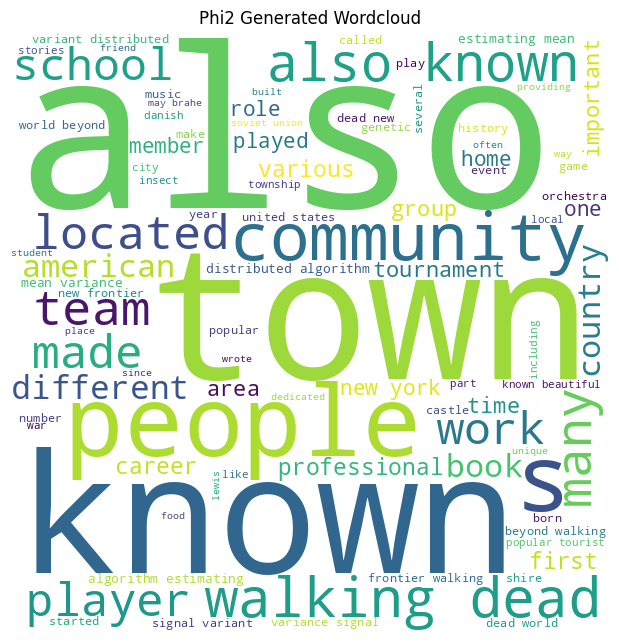

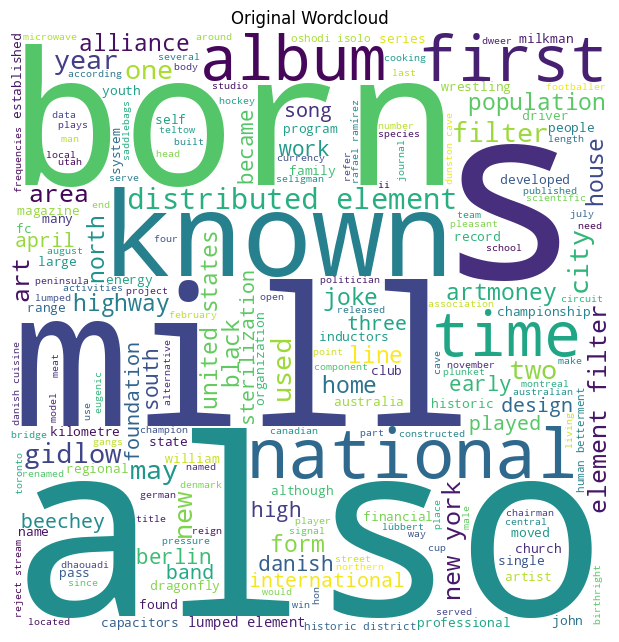

In [ ]:
# Wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width = 600, height = 600,
                          background_color ='white',
                          stopwords = set(),
                          min_font_size = 10
                          ).generate(text)

    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.title(title)
    plt.show()

qweasd = []
for asd in tokenized_generated:
  qweasd += tokenized_generated[asd]
generate_wordcloud(' '.join(qweasd), "Phi2 Generated Wordcloud")

print("\n\n\n")

concat_result = []
for asd in tokenized_original:
  concat_result += tokenized_original[asd]
generate_wordcloud(' '.join(concat_result), "Original Wordcloud")

## Init Second Model and Generate Summaries Again

In [ ]:
# https://huggingface.co/TheBloke/vicuna-7B-v1.3-GPTQ
from transformers import pipeline


model_name_or_path = "TheBloke/vicuna-7B-v1.3-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
#model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
          #model_basename=model_basename,
          use_safetensors=True,
          trust_remote_code=True,
          #use_triton=True,
          device="cuda:0",
          quantize_config=None
        ).to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
vicuna_summaries = {}
for index, row in sub.iterrows():
    word = row['word']
    print(f"Lenght of OG: {sum([1 for w in row['summary']])}")
    print(row['summary'])
    original_summaries[row['word']] = row['summary']
    try:
        # make up some cool prompt
        prompt = "Write a summary about Guy Fieri"
        prompt_template=f'''A chat between a curious human and an artificial intelligence assistant. The assistant provides summaries, in english, to the user based on words they are curious about, much like the summaries found at the beginning of wikipedia articles

        USER: Write a wikipedia-like summary, in english, about Guy Fieri
        ASSISTANT: Guy Ramsay Fieri is an American restaurateur, author, and an Emmy Award winning television presenter. He co-owned three now defunct restaurants in California. He licenses his name to restaurants in cities all over the world, and is known for hosting various television series on the Food Network. By 2010, The New York Times reported that Fieri had become the "face of the network", bringing an "element of rowdy, mass-market culture to American food television" and that his "prime-time shows attract more male viewers than any others on the network".
        USER: Write a wikipedia-like summary, in english, about {word}
        ASSISTANT:

        '''
        # Generate summary
        input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
        output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=300)

        summary = tokenizer.decode(output[0])
        print(f"Length of summary: {sum([1 for w in summary])}")

        # Only add the parts after the prompt (e.g. don't include "Write a summary about....")
        vicuna_summaries[word] = " ".join(summary.split("\n")[7:])
    except Exception as e:
        print(f"Error summarizing word {word}: {e}")

Lenght of OG: 108
Saimoni Tamani (born 14 November 1944) is a Fijian former athlete who specialized in running the 400 metres.
Length of summary: 1076
Lenght of OG: 173
The Sorrento Peninsula or Sorrentine Peninsula is a peninsula located in southern Italy that separates the Gulf of Naples to the north from the Gulf of Salerno to the south.
Length of summary: 2154
Lenght of OG: 818
The Dual Work Exchanger Energy Recovery (DWEER) is an energy recovery device. In the 1990s developed by DWEER Bermuda and licensed by Calder AG for use in the Caribbean. Seawater reverse osmosis (SWRO) needs high pressure and some of the reject stream can be reused by using this device. According to Calder AG, 97% of the energy in the reject stream is recovered. The DWEER system uses a piston doublechamber reciprocating hydraulically driven pump, and a patented valve system in a high pressure batch process with large pressure vessels, similar to a locomotive, to capture and transfer the energy lost in the me

## Cleaning and BM25 Ranking of Second Generated Summaries

Again, aslo calculate cosine similarity

In [ ]:
# Tokenized Vicuna Generated (summaries)
tok_vic_gen = {}
for w in vicuna_summaries:
  # Remove garbage
  vicuna_summaries[w] = re.sub(r"\s+", " ", vicuna_summaries[w])
  vicuna_summaries[w] = re.sub(r"<.*?>", "", vicuna_summaries[w])

# Tokenize
for word in vicuna_summaries:
  res = word_tokenize(vicuna_summaries[word].lower())
  tok_vic_gen[word] = res

print(tok_vic_gen)

# Remove stop words
for w in tok_vic_gen:
  tok_vic_gen[w] = [b for b in tok_vic_gen[w] if b not in stop_words]

print(tok_vic_gen)

{'Saimoni Tamani': ['很抱歉，我无法提供有关', '“', 'saimoni', 'tamani', '”', '的概述，因为我无法找到任何有关这个人物的信息。请提供更多的信息，以便我能够为您提供更准确的答案。'], 'Sorrento Peninsula': ['the', 'sorrentine', 'peninsula', 'is', 'a', 'long', ',', 'narrow', 'promontory', 'in', 'southern', 'italy', ',', 'extending', 'from', 'the', 'gulf', 'of', 'naples', 'to', 'the', 'bay', 'of', 'salerno', '.', 'it', 'is', 'situated', 'on', 'the', 'southwestern', 'coast', 'of', 'the', 'country', ',', 'and', 'is', 'the', 'largest', 'peninsula', 'in', 'the', 'region', 'of', 'campania', '.', 'the', 'peninsula', 'is', 'known', 'for', 'its', 'stunning', 'scenery', ',', 'which', 'includes', 'beautiful', 'beaches', ',', 'picturesque', 'towns', ',', 'and', 'the', 'majestic', 'mount', 'vesuvius', '.', 'the', 'sorrentine', 'peninsula', 'is', 'home', 'to', 'several', 'towns', ',', 'including', 'sorrento', ',', 'which', 'is', 'the', 'largest', 'and', 'most', 'well-known', ',', 'and', 'positano', ',', 'which', 'is', 'known', 'for', 'its', 'pastel-coloured', 'hou

In [ ]:
bm25 = BM25Okapi([tok_vic_gen[w] for w in tok_vic_gen])
# Get the scores for each generated summary against dataset summares
bm25_scores = [bm25.get_scores(tokenized_original[doc]) for doc in tokenized_original]
#bm25_scores = [bm25.get_scores(tok_vic_gen[doc]) for doc in tok_vic_gen]

# Assign each "head" term a series of scores
vic_res = {}
for idx, key in enumerate(tok_vic_gen):
  vic_res[key] = {}
  for idxx, bbb in enumerate(tokenized_original):
    vic_res[key][bbb] = bm25_scores[idx][idxx]


vicuna_bm25_top_scores = []
vicuna_bm25_correct_scores = []
vicuna_incorrect = []
vicuna_cosine = []
# Iter over each term and print dataset summary and all related scores
for w in vic_res:
  print(f"Rankings for the term: {w} \n")
  print(f"original summary: {original_summaries[w]} \n")

  # For cosine similarity
  orig_summary_embedding = sentenceTF.encode(original_summaries[w], convert_to_tensor=True)

  # Sort the ranked summaries highest -> lowest
  bob = sorted(vic_res[w].items(), key=lambda item: item[1], reverse=True)

  for i in range(0, len(bob)):
    print(f"{i + 1}. {bob[i]}")
    # If we are at first entry show the generated summary (and cosine similarity),
    # however this might not be the expeceted term so....
    if i == 0:
      vicuna_bm25_top_scores.append(float(bob[i][1]))
      if bob[i][0] == w:
        vicuna_bm25_correct_scores.append(bob[i][1])
      print(f"\tgenerated summary: {vicuna_summaries[bob[i][0]]}")
      gen_summary_embedding = sentenceTF.encode(vicuna_summaries[bob[i][0]], convert_to_tensor=True)
      # Duplicate code yeah yeah
      print(f"\tCosinie similarity to original: {1 - scipy.spatial.distance.cosine(gen_summary_embedding.cpu(), orig_summary_embedding.cpu())}")
      vicuna_cosine.append(1 - scipy.spatial.distance.cosine(gen_summary_embedding.cpu(), orig_summary_embedding.cpu()))
    # Here we instead say if we find the expected term, show that generated
    # summary instead (and cosine similarity)
    elif bob[i][0] == w:
      vicuna_bm25_correct_scores.append(bob[i][1])
      print("\tActual target term")
      print(f"\tgenerated summary: {vicuna_summaries[bob[i][0]]}")
      vicuna_incorrect.append(bob[i][0])
      gen_summary_embedding = sentenceTF.encode(vicuna_summaries[bob[i][0]], convert_to_tensor=True)
      print(f"\tCosinie similarity to original: {1 - scipy.spatial.distance.cosine(gen_summary_embedding.cpu(), orig_summary_embedding.cpu())}")
  print("\n----------------------\n")

Rankings for the term: Saimoni Tamani 

original summary: Saimoni Tamani (born 14 November 1944) is a Fijian former athlete who specialized in running the 400 metres. 

1. ('Saimoni Tamani', 12.009527932875772)
	generated summary:  很抱歉，我无法提供有关“Saimoni Tamani”的概述，因为我无法找到任何有关这个人物的信息。请提供更多的信息，以便我能够为您提供更准确的答案。
	Cosinie similarity to original: 0.3596652150154114
2. ('William Lewis (Australian politician)', 4.962275665410289)
3. ('Lars Melvang', 3.7472876574854115)
4. ('David Williamson', 3.363348620846841)
5. ('Berlin-Lichterfelde Süd–Teltow Stadt railway', 3.120662201170092)
6. ('Clay Township, Lancaster County, Pennsylvania', 2.959981377435948)
7. ('Plunket Point', 2.30321312647396)
8. ('New York Interschool', 1.9947509079260901)
9. ('Erika Szuh', 1.9779426851124982)
10. ('William Self (organist)', 1.890424326638753)
11. ('Oshodi-Isolo', 1.7169067249369505)
12. ('Adam Beechey', 1.5641519535772421)
13. ('Roswell George Mills', 1.5165616596357883)
14. ('Brian Kilrea', 1.4227695894719317)
15

## Visualisation

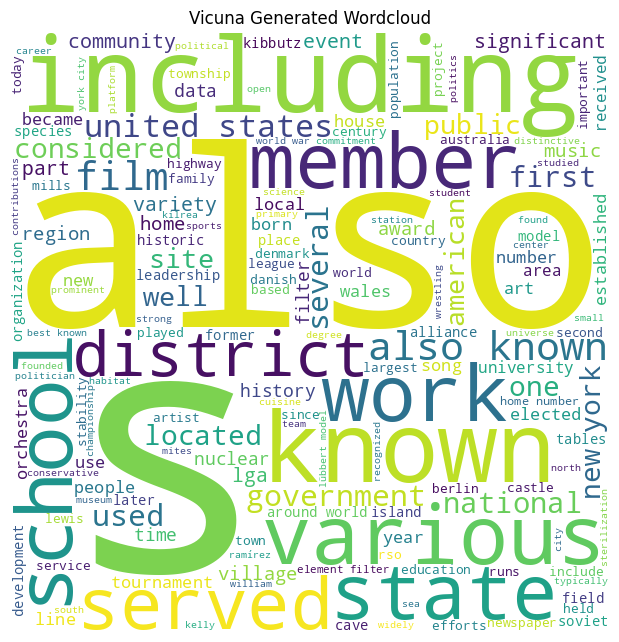

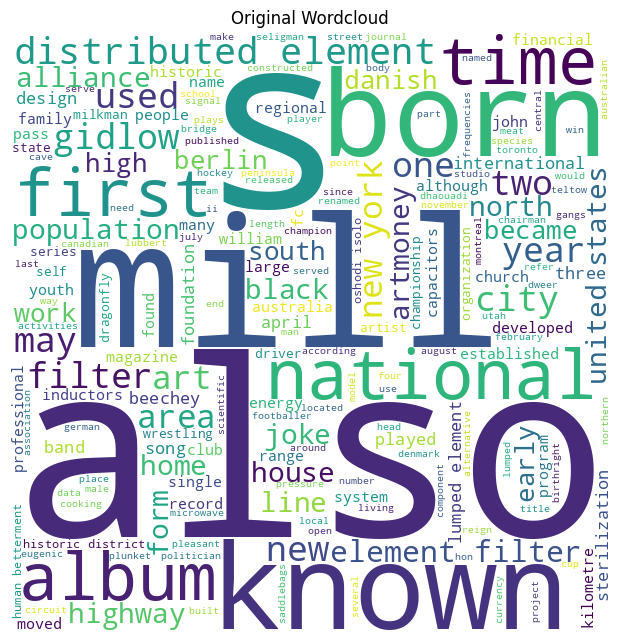

In [ ]:
# wordclouds
vicuna_concat = []
for asd in tok_vic_gen:
  vicuna_concat += tok_vic_gen[asd]
generate_wordcloud(' '.join(vicuna_concat), "Vicuna Generated Wordcloud")

print("\n\n\n")

concat_result = []
for asd in tokenized_original:
  concat_result += tokenized_original[asd]
generate_wordcloud(' '.join(concat_result), "Original Wordcloud")

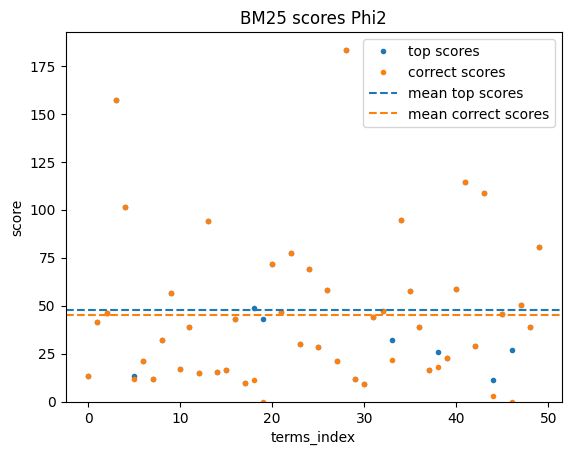


 ---------------- 



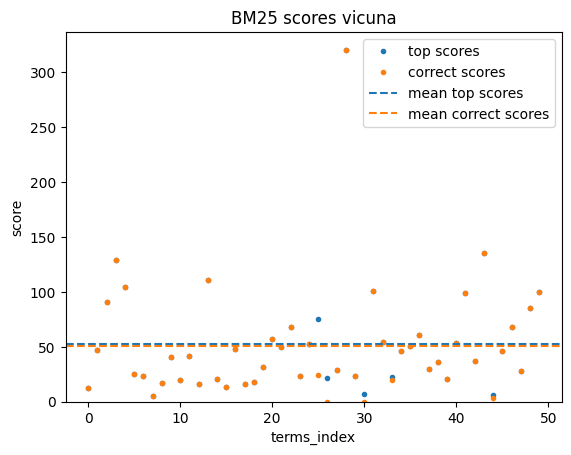


 ---------------- 

Number of times the PHI2 generated summary was not ranked first for it's term: 7/50 (14.000000000000002%). 
The terms which failed: ['Daniel Teklehaimanot', 'Erika Szuh', 'You & Me (The Flirts song)', 'May Brahe', 'Milkman joke', 'Ben Nunn', 'Artmoney']
Number of times the Vicuna generated summary was not ranked first for it's term: 5/50 (10.0%). 
The terms which failed: ['Hearts of the Innocent', 'Zouheir Dhaouadi', 'Cycloglypha', 'May Brahe', 'Ben Nunn']

 ---------------- 

PHi2 BM25 score, 25th percentile:  21.26744359220666
Phi2 BM25 score, 50th percentile (Median):  40.14172220621127
PHi2 BM25 score, 75th percentile:  58.19389129603355

 ---------------- 

Vicuna BM25 score, 25th percentile:  21.60818739113397
Vicuna BM25 score, 50th percentile (Median):  41.13863246068928
Vicuna BM25 score, 75th percentile:  65.8951662125967


In [ ]:
color1 = "tab:blue"
color2 = "tab:orange"
# stats
# BM25 scores
plt.plot(range(sampsize), phi2_bm25_top_scores, '.', label="top scores", color=color1)
plt.plot(range(sampsize), phi2_bm25_correct_scores, '.', label="correct scores", color=color2)
plt.axhline(np.mean(phi2_bm25_top_scores), linestyle="--", label="mean top scores", color=color1)
plt.axhline(np.mean(phi2_bm25_correct_scores), linestyle="--", label="mean correct scores", color=color2)
plt.axis((None, None, 0, None))
#plt.xticks(range(sampsize))
plt.title("BM25 scores Phi2")
plt.ylabel("score")
plt.xlabel("terms_index")
plt.legend()
plt.show()

print("\n ---------------- \n")


plt.plot(range(sampsize), vicuna_bm25_top_scores, '.', label="top scores", color=color1)
plt.plot(range(sampsize), vicuna_bm25_correct_scores, '.', label="correct scores", color=color2)
plt.axhline(np.mean(vicuna_bm25_top_scores), linestyle="--", label="mean top scores", color=color1)
plt.axhline(np.mean(vicuna_bm25_correct_scores), linestyle="--", label="mean correct scores", color=color2)
plt.axis((None, None, 0, None))
#plt.xticks(range(sampsize))
plt.title("BM25 scores vicuna")
plt.ylabel("score")
plt.xlabel("terms_index")
plt.legend()
plt.show()

#print(f"Average BM25 score phi2: {sum([w for w in phi2_bm25_scores])/len(phi2_bm25_scores)}")
#print(f"Average BM25 score vicuna: {sum([w for w in vicuna_bm25_scores])/len(vicuna_bm25_scores)}")

print("\n ---------------- \n")

# Failed summaries, where failed == expected term is not ranked first
print(f"Number of times the PHI2 generated summary was not ranked first for it's term: {len(phi2_incorrect)}/{sampsize} ({(len(phi2_incorrect)/sampsize)*100}%). \nThe terms which failed: {phi2_incorrect}")
print(f"Number of times the Vicuna generated summary was not ranked first for it's term: {len(vicuna_incorrect)}/{sampsize} ({(len(vicuna_incorrect)/sampsize)*100}%). \nThe terms which failed: {vicuna_incorrect}")

print("\n ---------------- \n")

# Percentiles of bm25 top scores
print("PHi2 BM25 score, 25th percentile: ", np.percentile(phi2_bm25_top_scores, 25))
print("Phi2 BM25 score, 50th percentile (Median): ", np.percentile(phi2_bm25_top_scores, 50))
print("PHi2 BM25 score, 75th percentile: ", np.percentile(phi2_bm25_top_scores, 75))

print("\n ---------------- \n")

print("Vicuna BM25 score, 25th percentile: ", np.percentile(vicuna_bm25_top_scores, 25))
print("Vicuna BM25 score, 50th percentile (Median): ", np.percentile(vicuna_bm25_top_scores, 50))
print("Vicuna BM25 score, 75th percentile: ", np.percentile(vicuna_bm25_top_scores, 75))

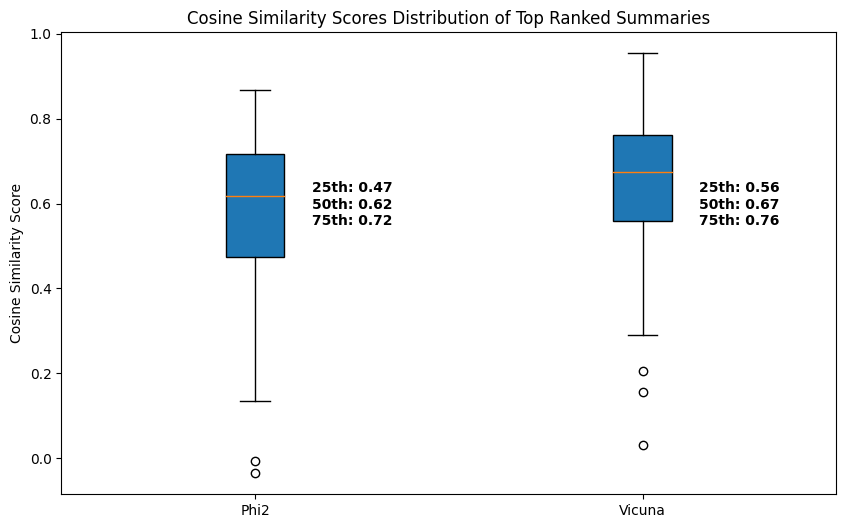

In [ ]:
# Cool boxplots of the cosine similarities for the top ranked summary
# this of course includes those summaries which are "incorrectly" ranked
# above the expected term, resulting in large boxplot tails if we have failures
plt.figure(figsize=(10, 6))
plt.boxplot([phi2_cosine, vicuna_cosine], vert=True, patch_artist=True)

plt.title('Cosine Similarity Scores Distribution of Top Ranked Summaries')
plt.ylabel('Cosine Similarity Score')

# create legends containg the percentiles for easier interpretation
for i, percentiles in enumerate([np.percentile(phi2_cosine, [25, 50, 75]), np.percentile(vicuna_cosine, [25, 50, 75])]):
    plt.text(i + 1.25, 0.55, f'25th: {percentiles[0]:.2f}\n50th: {percentiles[1]:.2f}\n75th: {percentiles[2]:.2f}',
             horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.xticks([1, 2], ['Phi2', 'Vicuna'])

plt.show()